In [1]:
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             CountVectorizer)

from sklearn.naive_bayes import (BernoulliNB,
                                 GaussianNB,
                                 MultinomialNB)
from typing import (NoReturn,
                    Union)
nltk.download('wordnet')





[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv(r'financial-news-sentiment.csv', decimal=',',sep=";",encoding='ansi')
data = data[data.columns[:-2]]

show info data выводит полную информацию о датасете: количество элементов в датасете на фиксированные класс, информацию о колонках, распределение классов

inforamtion about dataset: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12424 entries, 0 to 12423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12291 non-null  object
 1   label   11934 non-null  object
dtypes: object(2)
memory usage: 194.2+ KB


 unique classes names: 
 ['Bearish' 'Bullish' nan 'Neutral' ' Exp. -3MM'
 ' that\'s actuallвЂ¦ https://t.co/fk7asQHL64"'
 ' cashless self-order kiosks are leaving outвЂ¦ https://t.co/eDBearishY4vGNeutral5W"'
 ' it would be iвЂ¦ https://t.co/9Vq8a8QY3g"'
 ' 3Bullish are tech companies' 'вЂ¦ https://t.co/tW98HHQBearishhb"'
 ' multifunвЂ¦ https://t.co/L4lHjDTMXc"'
 ' Nasdaq VP and Head of Capital Markets'
 ' answered by @Jess_Shankleman https://t.co/V7NeutralzSgbNnc"'
 " celebrate 'Drygiving' with these non-boozy alternatives."
 ' the #NasdaqFam is setting the pace andвЂ¦ https://t.co/hFU6Y6EUBullisht"'
 ' breaking 7 consecutive up weeksвЂ¦ https://t.co/kBearish4JSxx56

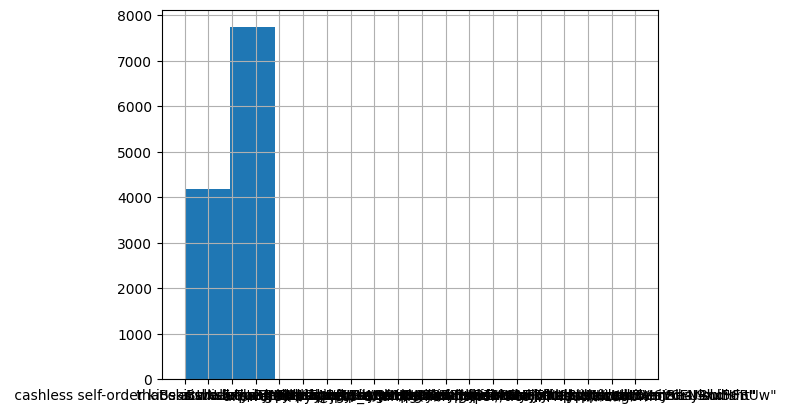

In [3]:
def show_info_data(dataF: pd.DataFrame,
                   show_n_elements: int = 5) -> NoReturn:
    

    print('inforamtion about dataset: \n\n')
    data.info()
    print('\n\n', 'unique classes names: \n', data[data.columns[-1]].unique(), '\n\n')
    print('Value counts')
    print(data[data.columns[-1]].value_counts(),'\n\n')
    print('Classes distribution', data[data.columns[-1]].hist().get_figure())

show_info_data(data, show_n_elements = 8)

Кодируем метки классы в int формат

In [4]:
def transform_label(dataF: pd.DataFrame,
                label_name: str,
                class_labels: np.array) -> pd.DataFrame:
    
    dataF[label_name] = dataF[label_name].apply(lambda text: text if text in class_labels else np.nan)
    dataF.dropna(inplace=True)
    dataF[label_name] = dataF[label_name].astype('category').cat.codes
    return dataF

classlabels = ['Bearish', 'Bullish','Neutral']
labelname = 'label'
clear_data_label = transform_label(data, label_name=labelname, class_labels=classlabels)
clear_data_label['label'].astype('category').cat.codes.unique()

array([0, 1, 2], dtype=int8)

inforamtion about dataset: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11917 entries, 0 to 12423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11917 non-null  object
 1   label   11917 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 197.8+ KB


 unique classes names: 
 [0 1 2] 


Value counts
2    7732
1    2397
0    1788
Name: label, dtype: int64 


Classes distribution Figure(640x480)


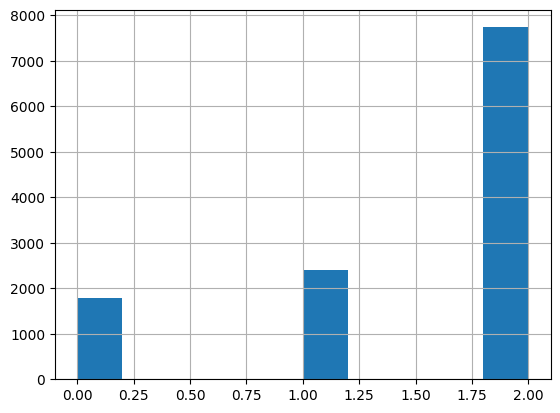

In [5]:
show_info_data(clear_data_label)

Трансформируем фичи: избавляемся от ненужных символов, числовых значений, знаков препинания, лемматизируем и убираем стоп- слова

In [6]:
def lemmatize_feature_columns(dataF: pd.DataFrame,
                              columns_to_transform: Union[list, np.array]) -> pd.DataFrame:
    
    stopwords = nltk.corpus.stopwords.words('english')
    lemmatize = nltk.WordNetLemmatizer().lemmatize
    #tokenize = nltk.word_tokenize

    import pandarallel
    from pandarallel import pandarallel
    import re

    pandarallel.initialize(progress_bar=True, nb_workers=8)

    for columns in columns_to_transform:
        
        dataF[columns] = dataF[columns].parallel_apply(lambda text: re.sub(r'[^A-Za-z]' ,' ' ,text))
        dataF[columns] = dataF[columns].parallel_apply(lambda text: text.split())
        dataF[columns] = dataF[columns].parallel_apply(lambda text: ' '.join(filter(lambda t: t not in stopwords, text)))
        dataF[columns] = dataF[columns].parallel_apply(lambda text: lemmatize(text).lower())

    return data

not_label_columns_to_transform = ['text']
data = lemmatize_feature_columns(clear_data_label, columns_to_transform=not_label_columns_to_transform )
data


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,text,label
0,bynd jpmorgan reels expectations beyond meat h...,0
1,ccl rcl nomura points bookings weakness carniv...,0
2,cx cemex cut credit suisse j p morgan weak bui...,0
3,ess btig research cuts neutral https co mcyfts...,0
4,fnko funko slides piper jaffray pt cut https c...,0
...,...,...
12419,stocks making biggest moves midday td ameritra...,2
12420,stocks making biggest moves premarket fitbit x...,2
12421,stocks making biggest moves premarket home dep...,2
12422,stocks making biggest moves premarket td ameri...,2


inforamtion about dataset: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11917 entries, 0 to 12423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11917 non-null  object
 1   label   11917 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 197.8+ KB


 unique classes names: 
 [0 1 2] 


Value counts
2    7732
1    2397
0    1788
Name: label, dtype: int64 


Classes distribution Figure(640x480)


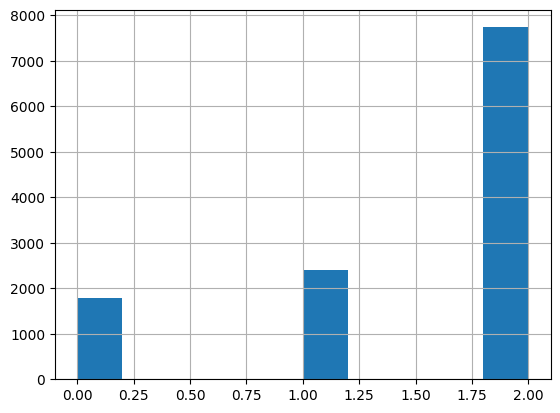

In [7]:
show_info_data(dataF=data)

Class upsampling балансирует классы: по -началу интересно посмотреть на данные которые сэмплируются и как с ними срабатывает балансировка

In [8]:
def class_upsampling(dataF: pd.DataFrame,
                     sample_f: Union[None, float] = 0.5) -> pd.DataFrame:
    
    from sklearn.utils import resample

    labels = dataF[dataF.columns[-1]]
    max_value = max(labels.value_counts())
    sample_result = []
    
    for classes in labels.unique():
        data_w= dataF[labels == classes]

        samples = resample(data_w, replace=True, n_samples=max_value, random_state=42)
        sample_result.append(samples)
    
    data_s = pd.concat(sample_result)
    if sample_f is None:
        return data_s
    else:
        return data_s.sample(frac=sample_f, replace=True, random_state=13)
   

data_c = class_upsampling(data, sample_f=0.5)
data_c[data_c.columns[-1]].value_counts()

2    3931
1    3885
0    3782
Name: label, dtype: int64

Смотрим на информацию о датасете, при сбалансированных классах

inforamtion about dataset: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793 entries, 3818 to 10461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11793 non-null  object
 1   label   11793 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 195.8+ KB


 unique classes names: 
 [0 1 2] 


Value counts
0    3931
1    3931
2    3931
Name: label, dtype: int64 


Classes distribution Figure(640x480)


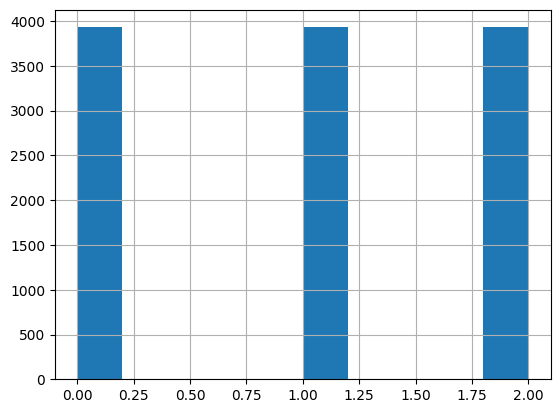

In [9]:
data = class_upsampling(data_c, sample_f=None)
show_info_data(dataF=data)

Векторизуем данные

In [10]:
def vectorize(dataF, sw: list = None, typeVec:str = 'TF-IDF', ngrams: tuple = (1,1))-> tuple:

    if typeVec == 'TF-IDF':
        vec = TfidfVectorizer(ngram_range=ngrams, stop_words=sw)
        data_vec = vec.fit_transform(dataF)

        return vec.get_feature_names_out(), data_vec

    if typeVec == 'Count':
        vec = CountVectorizer(ngram_range=ngrams, stop_words=sw)
        data_vec = vec.fit_transform(dataF)

        return vec.get_feature_names_out(), data_vec
    
features_names, X = vectorize(data['text'])
y = data['label'].to_numpy()
        

Смотрим фичи

In [11]:
features_names

array(['aaas', 'aacitcwia', 'aakk', ..., 'zzh', 'zzz', 'zzzi'],
      dtype=object)

Разбиваем выборку на тестовую и тренировочную

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, train_size=0.8)

Будет расспараллеливать N переданных моделей.
Метод model_parallel_train выводит классификационные отчет
и возвращает предсказанные метки класса

In [13]:
def model_parallel_train(multimodel_train: list,
                         data_x_train: Union[np.array, pd.DataFrame],
                         data_y_train: Union[np.array, pd.Series],
                         data_x_test: Union[np.array, pd.DataFrame],
                         data_y_test: Union[np.array, pd.DataFrame],
                         num_threads: int = 8):
    
    predict_results = []
    from joblib import parallel_backend

    with parallel_backend('threading', n_jobs=num_threads):
        
        for i in range(len(multimodel_train)):
            model = multimodel_train[i]
            model.fit(data_x_train, data_y_train)
            data_y_predict = model.predict(data_x_test)
            predict_results.append(data_y_predict)
            print(f'report model {model} \n',metrics.classification_report(data_y_test, data_y_predict), '\n')
        
        return predict_results




Формируем список из моделей и обучаем их на данных

*Сохранение моделей - фича по усмотрению пользователя,можно добавить загрузку и выгрузку

In [14]:
multimodel_train = [BernoulliNB(), GaussianNB(), MultinomialNB()]
model_parallel_train(multimodel_train, X_train,y_train,X_test,y_test)

report model BernoulliNB() 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       780
           1       0.84      0.95      0.89       786
           2       0.94      0.82      0.87       793

    accuracy                           0.89      2359
   macro avg       0.90      0.89      0.89      2359
weighted avg       0.90      0.89      0.89      2359
 

report model GaussianNB() 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       780
           1       0.89      0.94      0.91       786
           2       0.95      0.86      0.90       793

    accuracy                           0.91      2359
   macro avg       0.91      0.91      0.91      2359
weighted avg       0.91      0.91      0.91      2359
 

report model MultinomialNB() 
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       780
           1       0.85      0.92    

[array([0, 2, 0, ..., 2, 1, 2], dtype=int8),
 array([0, 2, 0, ..., 2, 0, 2], dtype=int8),
 array([0, 2, 0, ..., 2, 0, 2], dtype=int8)]

Сама лучшая моделька, в смысле равномерного F1-score показывает GaussianNB